# News Classifier with Word2Vec + TF-IDF + StandardScaler + Learning Curve

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import re
import nltk
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

/Users/finko/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package punkt to /Users/finko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/finko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/finko/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/finko/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/finko/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# Load and merge data
df = pd.read_csv("/Users/finko/Desktop/Ironhack/nlp-project/dataset/data.csv")
df['combined_text'] = df['title'] + ' ' + df['text'] + ' ' + df['subject']
df.drop(['title', 'text', 'subject', 'date'], axis=1, inplace=True)

X = df['combined_text']
y = df['label']

X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [4]:
import nltk

resources = [
    'punkt',
    'stopwords',
    'wordnet',
    'omw-1.4',
    'averaged_perceptron_tagger'
]

for res in resources:
    print(f"Downloading: {res}")
    nltk.download(res, quiet=False)


Downloading: punkt
Downloading: stopwords
Downloading: wordnet
Downloading: omw-1.4
Downloading: averaged_perceptron_tagger


[nltk_data] Downloading package punkt to /Users/finko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/finko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/finko/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/finko/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/finko/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
import nltk

# Force correct path
nltk.data.path.clear()
nltk.data.path.append("/Users/finko/nltk_data")

# Optionally verify it's searching there
print("NLTK is now searching these paths:")
print(nltk.data.path)

NLTK is now searching these paths:
['/Users/finko/nltk_data']


In [6]:
import nltk
import os

# Make sure path is correct
custom_path = "/Users/finko/nltk_data"
os.makedirs(custom_path, exist_ok=True)

# Force NLTK to use ONLY your local path
nltk.data.path.clear()
nltk.data.path.append(custom_path)

# Confirm NLTK is checking the right place
print("NLTK search paths:")
print(nltk.data.path)

# Force-download ALL required packages again, into the right folder
required = {
    'punkt': 'tokenizers/punkt',
    'stopwords': 'corpora/stopwords',
    'wordnet': 'corpora/wordnet',
    'omw-1.4': 'corpora/omw-1.4',
    'averaged_perceptron_tagger': 'taggers/averaged_perceptron_tagger'
}

for name, path in required.items():
    try:
        nltk.data.find(path)
        print(f"Found: {name}")
    except LookupError:
        print(f"Downloading: {name}")
        nltk.download(name, download_dir=custom_path)

NLTK search paths:
['/Users/finko/nltk_data']
Found: punkt
Found: stopwords
Downloading: wordnet
Downloading: omw-1.4
Found: averaged_perceptron_tagger


[nltk_data] Downloading package wordnet to /Users/finko/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/finko/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Ensure the preprocessing_pipeline function is defined
if 'preprocessing_pipeline' not in globals():
	stop_words = set(stopwords.words("english"))
	lemmatizer = WordNetLemmatizer()

	def pre_token_cleanup(text):
		text = re.sub(r'<.*?>', '', text)
		text = re.sub(r'http\S+|www\S+|https\S+', '', text)
		text = text.encode('ascii', 'ignore').decode('utf-8')
		return text

	def get_wordnet_pos(word):
		tag = nltk.pos_tag([word])[0][1][0]
		tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
		return tag_dict.get(tag, wordnet.NOUN)

	def preprocessing_pipeline(text):
		text = pre_token_cleanup(text)
		tokens = word_tokenize(text, language="english")
		tokens = [word.lower() for word in tokens if word.isalpha()]
		tokens = [word for word in tokens if word not in stop_words]
		tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
		return tokens

# Ensure the required NLTK resource is downloaded
try:
	nltk.data.find('taggers/averaged_perceptron_tagger_eng')
except LookupError:
	nltk.download('averaged_perceptron_tagger_eng', download_dir=custom_path)

# Apply the preprocessing pipeline
X_train = X_train_text.apply(preprocessing_pipeline)

In [ ]:
# Preprocessing
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def pre_token_cleanup(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = text.encode('ascii', 'ignore').decode('utf-8')
    return text

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0]
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocessing_pipeline(text):
    text = pre_token_cleanup(text)
    tokens = word_tokenize(text, language="english")
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
    return tokens

X_train = X_train_text.apply(preprocessing_pipeline)
X_test = X_test_text.apply(preprocessing_pipeline)

In [ ]:
# Word2Vec + TF-IDF
w2v_model = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=1, workers=4)

def identity(x): return x

tfidf_vectorizer = TfidfVectorizer(analyzer=identity, min_df=0.01, max_df=0.9, ngram_range=(1, 3))
tfidf_vectorizer.fit(X_train)

idf_weights = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))

/Users/finko/Library/Python/3.9/lib/python/site-packages/sklearn/feature_extraction/text.py:533: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


In [ ]:
# Embedding with weighted Word2Vec + StandardScaler
def get_weighted_embedding(tokens, model, idf_dict):
    vecs = [model.wv[word] * idf_dict[word] for word in tokens if word in model.wv and word in idf_dict]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

doc_embeddings_train = np.array([get_weighted_embedding(doc, w2v_model, idf_weights) for doc in X_train])
doc_embeddings_test = np.array([get_weighted_embedding(doc, w2v_model, idf_weights) for doc in X_test])

# Standardize embeddings
scaler = StandardScaler()
doc_embeddings_train_std = scaler.fit_transform(doc_embeddings_train)
doc_embeddings_test_std = scaler.transform(doc_embeddings_test)

In [ ]:
# Train Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(doc_embeddings_train_std, y_train)
y_pred = model.predict(doc_embeddings_test_std)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9569


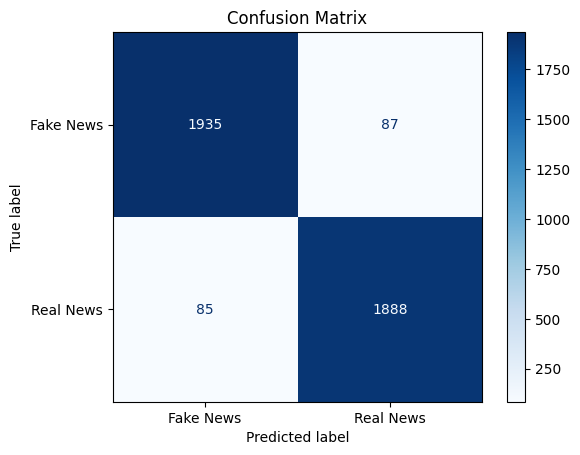

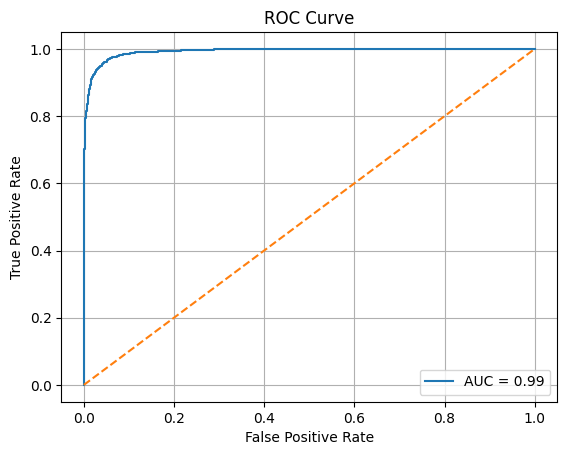

              precision    recall  f1-score   support

   Fake News       0.96      0.96      0.96      2022
   Real News       0.96      0.96      0.96      1973

    accuracy                           0.96      3995
   macro avg       0.96      0.96      0.96      3995
weighted avg       0.96      0.96      0.96      3995



In [ ]:
# Confusion Matrix and ROC
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake News", "Real News"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

y_proba = model.predict_proba(doc_embeddings_test_std)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

print(classification_report(y_test, y_pred, target_names=["Fake News", "Real News"]))

In [ ]:
# Learning Curve
def plot_learning_curve_for_embeddings(estimator, title, X_raw, y, embedding_func, cv, n_jobs=1,
                                       train_sizes=np.linspace(0.1, 0.9, 5)):
    train_scores, test_scores = [], []

    for frac in train_sizes:
        X_frac, _, y_frac, _ = train_test_split(X_raw, y, train_size=frac, random_state=42)
        X_emb = np.array([embedding_func(doc, w2v_model, idf_weights) for doc in X_frac])
        X_emb = scaler.fit_transform(X_emb)

        inner_cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
        train_result, test_result = [], []

        for train_idx, val_idx in inner_cv.split(X_emb):
            X_train_cv, X_val_cv = X_emb[train_idx], X_emb[val_idx]
            y_train_cv, y_val_cv = y_frac.iloc[train_idx], y_frac.iloc[val_idx]

            estimator.fit(X_train_cv, y_train_cv)
            train_result.append(estimator.score(X_train_cv, y_train_cv))
            test_result.append(estimator.score(X_val_cv, y_val_cv))

        train_scores.append(np.mean(train_result))
        test_scores.append(np.mean(test_result))

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores, 'o-', label='Training Score')
    plt.plot(train_sizes, test_scores, 'o-', label='Cross-validation Score')
    plt.xlabel("Training Set Fraction")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True)
    plt.legend(loc='best')
    plt.show()

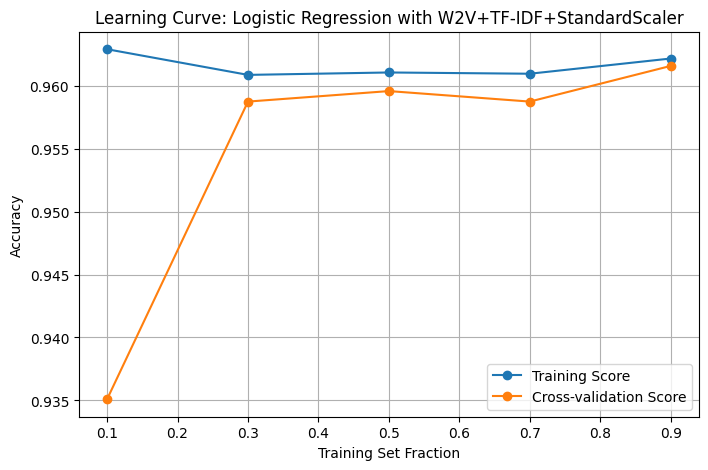

In [ ]:
plot_learning_curve_for_embeddings(
    estimator=LogisticRegression(max_iter=1000),
    title="Learning Curve: Logistic Regression with W2V+TF-IDF+StandardScaler",
    X_raw=X_train,
    y=y_train,
    embedding_func=lambda doc, model, idf_dict: get_weighted_embedding(doc, model, idf_dict),
    cv=ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
)